[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ksachdeva/rethinking-tensorflow-probability/blob/master/notebooks/08_conditional_manatees.ipynb)

# 8. Conditional Manatees

## Imports and utility functions


In [1]:
# Install packages that are not installed in colab
try:
  import google.colab
  !pip install -q watermark
  !pip install git+https://github.com/ksachdeva/rethinking-tensorflow-probability.git
except:
  pass

In [2]:
%load_ext watermark

In [3]:
# Core
import collections
import numpy as np
import arviz as az
import pandas as pd
import xarray as xr
import tensorflow as tf
import tensorflow_probability as tfp

# visualization 
import matplotlib.pyplot as plt

from rethinking.data import RethinkingDataset
from rethinking.data import dataframe_to_tensors
from rethinking.mcmc import sample_posterior

# aliases
tfd = tfp.distributions
tfb = tfp.bijectors
Root = tfd.JointDistributionCoroutine.Root

In [4]:
%watermark -p numpy,tensorflow,tensorflow_probability,arviz,scipy,pandas

numpy                 : 1.21.5
tensorflow            : 2.7.0
tensorflow_probability: 0.15.0
arviz                 : 0.11.4
scipy                 : 1.7.3
pandas                : 1.3.5



In [5]:
# config of various plotting libraries
%config InlineBackend.figure_format = 'retina'

## 8.1 Building an interaction

### 8.1.1 Making a rugged model

##### Code 8.1


Every inference is conditional on something whether we notice it or not !

So far in the book, it was assumed that the predictor variable has an independent association with the mean of the outcome. What if want to allow the association to be conditional ?

In [6]:
d = RethinkingDataset.Rugged.get_dataset()

# make log version of outcome
d["log_gdp"] = d["rgdppc_2000"].pipe(np.log)

# extract countries with GDP data
dd = d[d["rgdppc_2000"].notnull()].copy()

# rescale variables
dd["log_gdp_std"] = dd.log_gdp / dd.log_gdp.mean()
dd["rugged_std"] = dd.rugged / dd.rugged.max()

# split countries into Africa and not-Africa
d_A1 = dd[dd["cont_africa"] == 1]  # Africa
d_A0 = dd[dd["cont_africa"] == 0]  # not Africa

Note - terrain ruggedness is divided by the maximum value observed

##### Code 8.2

In [7]:
def model_8_1(rugged_std):
    def _generator():
        alpha = yield Root(tfd.Sample(tfd.Normal(loc=1., scale=1., name='alpha'), sample_shape=1))
        beta = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1., name='beta'), sample_shape=1))
        sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name='sigma'), sample_shape=1))
        
        mu = alpha + beta * (rugged_std - 0.215)
        
        log_gdp_std = yield tfd.Independent(tfd.Normal(loc=mu, scale=sigma), reinterpreted_batch_ndims=1)
        
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)  

##### Code 8.3

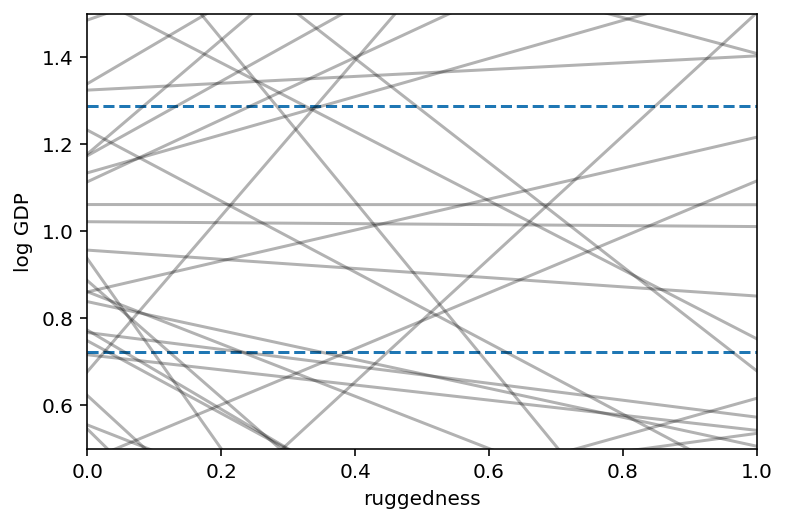

In [8]:
jdc_8_1 = model_8_1(rugged_std=dd["rugged_std"].values)

sample_alpha, sample_beta, sample_sigma, _ = jdc_8_1.sample(1000)

# set up the plot dimensions
plt.subplot(xlim=(0, 1), ylim=(0.5, 1.5),
            xlabel="ruggedness", ylabel="log GDP")
plt.gca().axhline(dd.log_gdp_std.min(), ls="--")
plt.gca().axhline(dd.log_gdp_std.max(), ls="--")

# draw 50 lines from the prior
rugged_seq = np.linspace(-0.1, 1.1, num=30)

jdc_8_1_test = model_8_1(rugged_std=rugged_seq)

ds, _ = jdc_8_1_test.sample_distributions(value=[
    sample_alpha,
    sample_beta,
    sample_sigma,
    None
])

mu = ds[-1].distribution.loc

for i in range(50):
    plt.plot(rugged_seq, mu[i], "k", alpha=0.3)

##### Code 8.4

In [9]:
np.sum(np.abs(sample_beta) > 0.6) / sample_beta.shape[0]

0.539

##### Code 8.5

In [10]:
tdf = dataframe_to_tensors('Rugged', dd, ['rugged_std', 'log_gdp_std'])

In [11]:
def model_8_1(rugged_std):
    def _generator():
        alpha = yield Root(tfd.Sample(tfd.Normal(loc=1., scale=0.1, name='alpha'), sample_shape=1))
        beta = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.3, name='beta'), sample_shape=1))
        sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name='sigma'), sample_shape=1))
        
        mu = alpha[...,tf.newaxis] + beta[...,tf.newaxis] * (rugged_std - 0.215)
        scale = sigma[...,tf.newaxis]
        
        log_gdp_std = yield tfd.Independent(
            tfd.Normal(loc=mu, scale=scale), reinterpreted_batch_ndims=1)
        
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)  


jdc_8_1 = model_8_1(tdf.rugged_std)

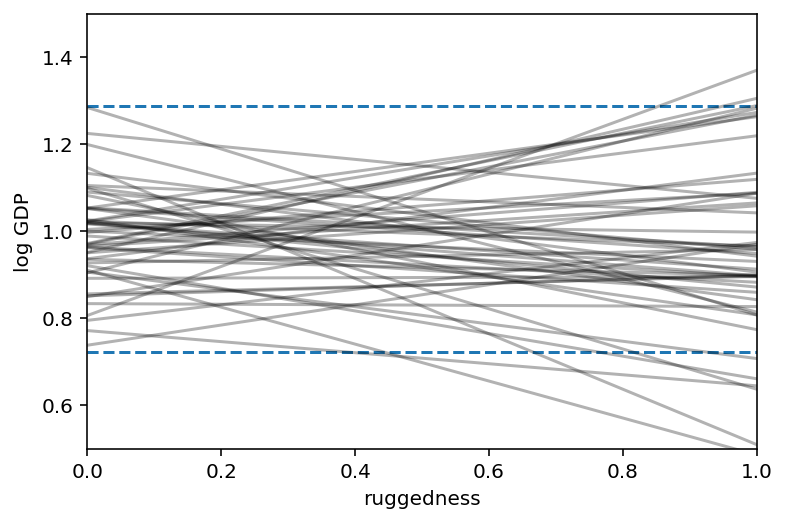

In [12]:
sample_alpha, sample_beta, sample_sigma, _ = jdc_8_1.sample(1000)

# set up the plot dimensions
plt.subplot(xlim=(0, 1), ylim=(0.5, 1.5),
            xlabel="ruggedness", ylabel="log GDP")
plt.gca().axhline(dd.log_gdp_std.min(), ls="--")
plt.gca().axhline(dd.log_gdp_std.max(), ls="--")

# draw 50 lines from the prior
rugged_seq = np.linspace(-0.1, 1.1, num=30)

jdc_8_1_test = model_8_1(rugged_std=rugged_seq)

ds, _ = jdc_8_1_test.sample_distributions(value=[
    sample_alpha,
    sample_beta,
    sample_sigma,
    None
])

mu = tf.squeeze(ds[-1].distribution.loc)

for i in range(50):
    plt.plot(rugged_seq, mu[i], "k", alpha=0.3)

##### Code 8.6

In [13]:
NUM_CHAINS_FOR_8_1 = 2

init_state = [
    tf.ones([NUM_CHAINS_FOR_8_1]),
    tf.zeros([NUM_CHAINS_FOR_8_1]),
    tf.ones([NUM_CHAINS_FOR_8_1]),
]


bijectors = [
    tfb.Identity(),
    tfb.Identity(),
    tfb.Exp(),    
]

posterior_8_1, trace_8_1 = sample_posterior(jdc_8_1,
                               observed_data=(tdf.log_gdp_std,),
                               params=['alpha', 'beta', 'sigma'],
                               init_state=init_state,
                               bijectors=bijectors)

az.summary(trace_8_1, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.000,0.011,0.984,1.018,0.001,0.000,448.0,460.0,1.0
beta,0.005,0.059,-0.100,0.090,0.003,0.002,311.0,310.0,1.0
sigma,0.139,0.008,0.127,0.150,0.000,0.000,391.0,506.0,1.0


### 8.1.2 Adding an indicator variable isn't enough

##### Code 8.7

In [14]:
# make variable to index Africa (0) or not (1)
dd["cid"] = np.where(dd.cont_africa.values == 1, 0, 1)

dd["cid"]

2      0
4      1
7      1
8      1
9      1
      ..
229    1
230    1
231    0
232    0
233    0
Name: cid, Length: 170, dtype: int64

##### Code 8.8

In [15]:
tdf = dataframe_to_tensors('Rugged', dd, {
    'rugged_std' : tf.float32,
    'log_gdp_std' : tf.float32,
    'cid' : tf.int32
})

In [16]:
def model_8_2(cid, rugged_std):
    def _generator():
        alpha = yield Root(tfd.Sample(tfd.Normal(loc=1., scale=0.1, name='alpha'), sample_shape=2))
        beta = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.3, name='beta'), sample_shape=1))
        sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name='sigma'), sample_shape=1))
        
        mu = tf.gather(alpha, cid, axis=-1) + beta[...,tf.newaxis] * (rugged_std - 0.215)
        scale = sigma[...,tf.newaxis]
        
        log_gdp_std = yield tfd.Independent(
            tfd.Normal(loc=mu, scale=scale), reinterpreted_batch_ndims=1)
        
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)  


jdc_8_2 = model_8_2(tdf.cid, rugged_std=tdf.rugged_std)

In [18]:
NUMBER_OF_CHAINS = 2

init_state = [
    tf.ones([NUMBER_OF_CHAINS, 2]),
    tf.zeros([NUMBER_OF_CHAINS]),
    tf.ones([NUMBER_OF_CHAINS]),
]

bijectors = [
    tfb.Identity(),
    tfb.Identity(),
    tfb.Exp(),
]

posterior_8_2, trace_8_2 = sample_posterior(
                                jdc_8_2, 
                                observed_data=(tdf.log_gdp_std,),
                                params=['alpha', 'beta', 'sigma'],
                                init_state=init_state,
                                bijectors=bijectors)

In [19]:
az.summary(trace_8_2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.879,0.016,0.854,0.904,0.001,0.001,481.0,439.0,1.01
alpha[1],1.049,0.010,1.034,1.065,0.000,0.000,974.0,352.0,1.00
beta,-0.046,0.049,-0.130,0.026,0.002,0.002,449.0,364.0,1.00
sigma,0.115,0.006,0.105,0.124,0.000,0.000,264.0,234.0,1.01


##### Code 8.9

In [20]:
def compute_and_store_log_likelihood_for_model_8_1():
    
    sample_alpha = posterior_8_1["alpha"]
    sample_beta  = posterior_8_1["beta"]
    sample_sigma = posterior_8_1["sigma"]
    
    ds, _ = jdc_8_1.sample_distributions(value=[
        sample_alpha, 
        sample_beta, 
        sample_sigma, 
        None
    ])
    
    log_likelihood_8_1 = ds[-1].distribution.log_prob(tdf.log_gdp_std).numpy()    
    
    # we need to insert this in the sampler_stats
    sample_stats_8_1 = trace_8_1.sample_stats
    
    coords = [sample_stats_8_1.coords['chain'], sample_stats_8_1.coords['draw'], np.arange(170)]

    sample_stats_8_1["log_likelihood"] = xr.DataArray(
        log_likelihood_8_1, 
        coords=coords,  
        dims=['chain', 'draw', 'log_likelihood_dim_0'])
    
compute_and_store_log_likelihood_for_model_8_1()

In [21]:
# We need to first compute the log likelihoods so as to be able to compare them
def compute_and_store_log_likelihood_for_model_8_2():
    
    sample_alpha = posterior_8_2["alpha"]
    sample_beta  = posterior_8_2["beta"]
    sample_sigma = posterior_8_2["sigma"]
    
    ds, _ = jdc_8_2.sample_distributions(value=[
        sample_alpha, 
        sample_beta, 
        sample_sigma,
        None
    ])
    
    log_likelihood_8_2 = ds[-1].distribution.log_prob(tdf.log_gdp_std).numpy() 
    
    # we need to insert this in the sampler_stats
    sample_stats_8_2 = trace_8_2.sample_stats
    
    coords = [sample_stats_8_2.coords['chain'], sample_stats_8_2.coords['draw'], np.arange(170)]

    sample_stats_8_2["log_likelihood"] = xr.DataArray(
        log_likelihood_8_2, 
        coords=coords,  
        dims=['chain', 'draw', 'log_likelihood_dim_0'])
    
compute_and_store_log_likelihood_for_model_8_2()

In [22]:
az.compare({"m8.1": trace_8_1,
            "m8.2": trace_8_2})

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m8.2,0,126.286700,3.975651,0.000000,0.971907,7.355123,0.000000,False,log
m8.1,1,94.282171,2.702271,32.004529,0.028093,6.440395,7.300988,False,log


##### Code 8.10

In [23]:
az.summary(trace_8_2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.879,0.016,0.854,0.904,0.001,0.001,481.0,439.0,1.01
alpha[1],1.049,0.010,1.034,1.065,0.000,0.000,974.0,352.0,1.00
beta,-0.046,0.049,-0.130,0.026,0.002,0.002,449.0,364.0,1.00
sigma,0.115,0.006,0.105,0.124,0.000,0.000,264.0,234.0,1.01


##### Code 8.11

In [24]:
diff_a = trace_8_2.posterior["alpha"][:,:, 0] - trace_8_2.posterior["alpha"][:,:, 1]

In [25]:
trace_8_2.posterior["diff_a"] = diff_a

az.summary(trace_8_2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.879,0.016,0.854,0.904,0.001,0.001,481.0,439.0,1.01
alpha[1],1.049,0.010,1.034,1.065,0.000,0.000,974.0,352.0,1.00
beta,-0.046,0.049,-0.130,0.026,0.002,0.002,449.0,364.0,1.00
sigma,0.115,0.006,0.105,0.124,0.000,0.000,264.0,234.0,1.01
diff_a,-0.170,0.019,-0.198,-0.139,0.001,0.001,519.0,396.0,1.00


##### Code 8.12

In [26]:
rugged_seq = np.linspace(start=-1, stop=1.1, num=30)

sample_alpha = posterior_8_2["alpha"][0]
sample_beta  = posterior_8_2["beta"][0]
sample_sigma = posterior_8_2["sigma"][0]

# compute mu over samples, fixing cid=1
jdc_8_2_test_cid_1 = model_8_2(np.repeat(1,30), rugged_std=rugged_seq)

ds, samples = jdc_8_2_test_cid_1.sample_distributions(value=[
    sample_alpha,
    sample_beta, 
    sample_sigma,
    None
])

mu_NotAfrica = tf.squeeze(ds[-1].distribution.loc)
mu_NotAfrica_mu = tf.reduce_mean(mu_NotAfrica, 0)
mu_NotAfrica_ci = tfp.stats.percentile(mu_NotAfrica, q=(1.5, 98.5), axis=0)

# compute mu over samples, fixing cid=0
jdc_8_2_test_cid_0 = model_8_2(np.repeat(0,30), rugged_std=rugged_seq)

ds, samples = jdc_8_2_test_cid_0.sample_distributions(value=[
    sample_alpha, 
    sample_beta, 
    sample_sigma,
    None
])

mu_Africa = tf.squeeze(ds[-1].distribution.loc)
mu_Africa_mu = tf.reduce_mean(mu_Africa, 0)
mu_Africa_ci = tfp.stats.percentile(mu_Africa, q=(1.5, 98.5), axis=0)

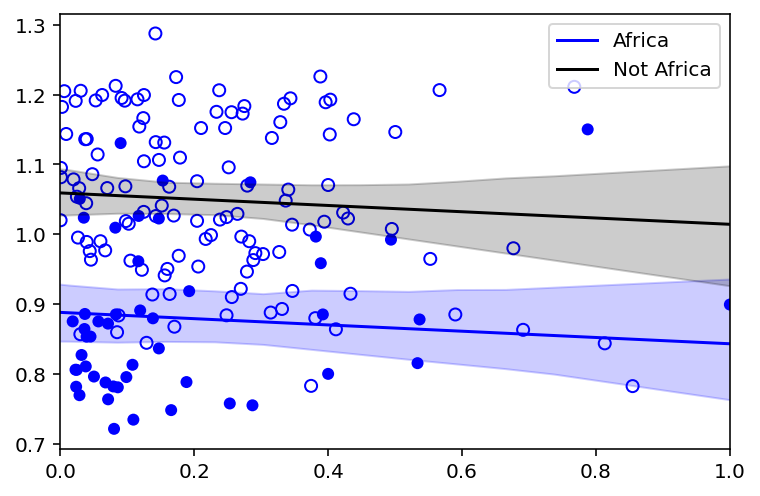

In [27]:
# draw figure 8.4 in the book [note - no code was provided for it in the book]

plt.xlim(0.0, 1.0)
plt.scatter(dd.rugged_std, dd.log_gdp_std, 
            edgecolors=["none" if i == 0 else "b" for i in dd["cid"]],
            facecolors=["none" if i == 1 else "b" for i in dd["cid"]])

# draw MAP line
plt.plot(rugged_seq, mu_Africa_mu, "b", label="Africa")
plt.fill_between(rugged_seq, mu_Africa_ci[0], mu_Africa_ci[1], color="b", alpha=0.2)

plt.plot(rugged_seq, mu_NotAfrica_mu, "k", label="Not Africa")
plt.fill_between(rugged_seq, mu_NotAfrica_ci[0], mu_NotAfrica_ci[1], color="k", alpha=0.2)

plt.legend();

##### Code 8.13

In [28]:
def model_8_3(cid, rugged_std):
    def _generator():
        alpha = yield Root(tfd.Sample(tfd.Normal(loc=1., scale=0.1, name='alpha'), sample_shape=2))
        beta = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.3, name='beta'), sample_shape=2))
        sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name='sigma'), sample_shape=1))
        
        mu = tf.gather(alpha, cid, axis=-1) + tf.gather(beta, cid, axis=-1) * (rugged_std - 0.215)
        scale = sigma[...,tf.newaxis]
        
        log_gdp_std = yield tfd.Independent(
            tfd.Normal(loc=mu, scale=scale), reinterpreted_batch_ndims=1)
        
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)  


jdc_8_3 = model_8_3(tdf.cid, rugged_std=tdf.rugged_std)

In [29]:
init_state = [
    tf.ones([NUMBER_OF_CHAINS, 2]),
    tf.zeros([NUMBER_OF_CHAINS, 2]),
    tf.ones([NUMBER_OF_CHAINS]),
]

bijectors = [
    tfb.Identity(),
    tfb.Identity(),
    tfb.Exp(),
]

posterior_8_3, trace_8_3 = sample_posterior(
                                jdc_8_3, 
                                observed_data=(tdf.log_gdp_std,),
                                params=['alpha', 'beta', 'sigma'],
                                num_samples=1000,
                                init_state=init_state,
                                bijectors=bijectors)

##### Code 8.14

In [30]:
az.summary(trace_8_3, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.887,0.015,0.861,0.911,0.000,0.000,1267.0,1132.0,1.00
alpha[1],1.051,0.010,1.035,1.068,0.000,0.000,1274.0,971.0,1.00
beta[0],0.132,0.073,0.030,0.267,0.005,0.003,225.0,425.0,1.01
beta[1],-0.143,0.055,-0.234,-0.060,0.002,0.002,660.0,890.0,1.00
sigma,0.111,0.006,0.101,0.121,0.000,0.000,542.0,699.0,1.00


##### Code 8.15

In [31]:
# We need to first compute the log likelihoods so as to be able to compare them
def compute_and_store_log_likelihood_for_model_8_3():
    
    sample_alpha = posterior_8_3["alpha"]
    sample_beta  = posterior_8_3["beta"]
    sample_sigma = posterior_8_3["sigma"]
    
    ds, _ = jdc_8_3.sample_distributions(value=[
        sample_alpha, 
        sample_beta, 
        sample_sigma,
        None
    ])
    
    log_likelihood_8_3 = ds[-1].distribution.log_prob(tdf.log_gdp_std).numpy()    
    
    # we need to insert this in the sampler_stats
    sample_stats_8_3 = trace_8_3.sample_stats
    
    coords = [sample_stats_8_3.coords['chain'], sample_stats_8_3.coords['draw'], np.arange(170)]

    sample_stats_8_3["log_likelihood"] = xr.DataArray(
        log_likelihood_8_3, 
        coords=coords,  
        dims=['chain', 'draw', 'log_likelihood_dim_0'])
    
compute_and_store_log_likelihood_for_model_8_3()

In [32]:
az.compare({"m8.1": trace_8_1,
            "m8.2": trace_8_2,
            "m8.3": trace_8_3})

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m8.3,0,129.714965,4.885031,0.000000,0.862,7.317584,0.000000,False,log
m8.2,1,126.286700,3.975651,3.428265,0.138,7.355123,3.255157,False,log
m8.1,2,94.282171,2.702271,35.432794,0.000,6.440395,7.451756,False,log


##### Code 8.16

In [33]:
az.waic(trace_8_3, pointwise=True)

/Users/ksachdeva/rethinkingtfp/lib/python3.7/site-packages/arviz/stats/stats.py:1460: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 2000 by 170 log-likelihood matrix

          Estimate       SE
elpd_waic   129.75     7.31
p_waic        4.85        -

There has been a warning during the calculation. Please check the results.

### 8.1.4 Plotting the interaction

##### Code 8.17

In [34]:
rugged_seq = np.linspace(start=-1, stop=1.1, num=30)

sample_alpha = posterior_8_3["alpha"][0]
sample_beta  = posterior_8_3["beta"][0]
sample_sigma = posterior_8_3["sigma"][0]

# compute mu over samples, fixing cid=1
jdc_8_3_test_cid_1 = model_8_3(np.repeat(1,30), rugged_std=rugged_seq)

ds, samples = jdc_8_3_test_cid_1.sample_distributions(value=[
    sample_alpha, 
    sample_beta, 
    sample_sigma,
    None
])

mu_NotAfrica = tf.squeeze(ds[-1].distribution.loc)
mu_NotAfrica_mu = tf.reduce_mean(mu_NotAfrica, 0)
mu_NotAfrica_ci = tfp.stats.percentile(mu_NotAfrica, q=(1.5, 98.5), axis=0)

# compute mu over samples, fixing cid=0
jdc_8_3_test_cid_0 = model_8_3(np.repeat(0,30), rugged_std=rugged_seq)

ds, samples = jdc_8_3_test_cid_0.sample_distributions(value=[
                sample_alpha, 
                sample_beta, 
                sample_sigma, 
                None
])

mu_Africa = tf.squeeze(ds[-1].distribution.loc)
mu_Africa_mu = tf.reduce_mean(mu_Africa, 0)
mu_Africa_ci = tfp.stats.percentile(mu_Africa, q=(1.5, 98.5), axis=0)


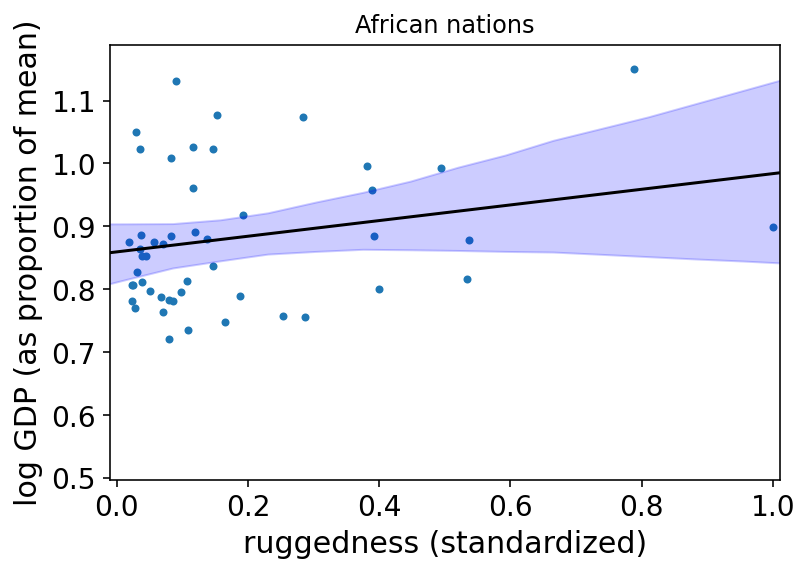

In [35]:
az.plot_pair(d_A1[["rugged_std", "log_gdp_std"]].to_dict(orient="list"))
plt.gca().set(xlim=(-0.01, 1.01), xlabel="ruggedness (standardized)",
              ylabel="log GDP (as proportion of mean)")

plt.plot(rugged_seq, mu_Africa_mu, "k")
plt.fill_between(rugged_seq, mu_Africa_ci[0], mu_Africa_ci[1], color="b", alpha=0.2)
plt.title("African nations")
plt.show()

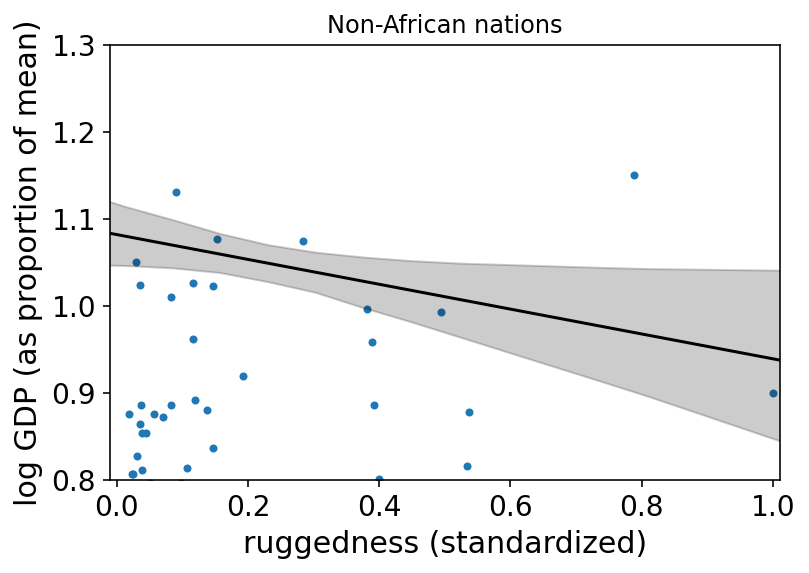

In [36]:
az.plot_pair(d_A1[["rugged_std", "log_gdp_std"]].to_dict(orient="list"))
plt.gca().set(xlim=(-0.01, 1.01), xlabel="ruggedness (standardized)",
              ylim=(0.8,1.3),
              ylabel="log GDP (as proportion of mean)")

plt.plot(rugged_seq, mu_NotAfrica_mu, "k")
plt.fill_between(rugged_seq, mu_NotAfrica_ci[0], mu_NotAfrica_ci[1], color="k", alpha=0.2)
plt.title("Non-African nations")
plt.show()

## 8.2 Symmetry of interactions

##### Code 8.18

In [37]:
# TODO - draw corresponding graph (Figure 8.6)

rugged_seq = np.linspace(start=-0.2, stop=1.2, num=30)
delta = mu_Africa_mu - mu_NotAfrica_mu

## 8.3 Continuous interactions

### 8.3.1 A winter flower

##### Code 8.19

In [39]:
d = RethinkingDataset.Tulips.get_dataset()
d.info()
d.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   bed     27 non-null     object 
 1   water   27 non-null     int64  
 2   shade   27 non-null     int64  
 3   blooms  27 non-null     float64
dtypes: float64(1), int64(2), object(1)
memory usage: 992.0+ bytes


,bed,water,shade,blooms
0,a,1,1,0.00
1,a,1,2,0.00
2,a,1,3,111.04
3,a,2,1,183.47
4,a,2,2,59.16


##### Code 8.20

In [40]:
d["blooms_std"] = d.blooms / d.blooms.max()
d["water_cent"] = d.water - d.water.mean()
d["shade_cent"] = d.shade - d.shade.mean()

##### Code 8.21

In [41]:
a = tfd.Normal(loc=0.5, scale=1.).sample((int(1e4),))
np.sum((a < 0) | (a > 1)) / a.shape[0]

0.6075

##### Code 8.22

In [42]:
a = tfd.Normal(loc=0.5, scale=0.25).sample((int(1e4),))
np.sum((a < 0) | (a > 1)) / a.shape[0]

0.0461

##### Code 8.23

In [43]:
tdf = dataframe_to_tensors("Tulip", d, ['blooms_std', 'water_cent', 'shade_cent'])

In [44]:
def model_8_4(water_cent, shade_cent,):
    def _generator():
        alpha = yield Root(tfd.Sample(tfd.Normal(loc=0.5, scale=0.25, name='alpha'), sample_shape=1))
        betaW = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.25, name='betaW'), sample_shape=1))
        betaS = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.25, name='betaS'), sample_shape=1))
        sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name='sigma'), sample_shape=1))
        
        mu = alpha[...,tf.newaxis] + betaW[...,tf.newaxis] * water_cent + betaS[...,tf.newaxis] * shade_cent
        scale = sigma[...,tf.newaxis]
        
        log_gdp_std = yield tfd.Independent(
            tfd.Normal(loc=mu, scale=scale), reinterpreted_batch_ndims=1)
        
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)  


jdc_8_4 = model_8_4(shade_cent=tdf.shade_cent, 
                    water_cent=tdf.water_cent)

In [45]:
init_state = [
    0.5 * tf.ones([NUMBER_OF_CHAINS]),
    tf.zeros([NUMBER_OF_CHAINS]),
    tf.zeros([NUMBER_OF_CHAINS]),
    tf.ones([NUMBER_OF_CHAINS]),
]

bijectors = [
    tfb.Identity(),
    tfb.Identity(),
    tfb.Identity(),
    tfb.Exp(),
]

posterior_8_4, trace_8_4 = sample_posterior(
                                jdc_8_4, 
                                observed_data=(tdf.blooms_std,),
                                params=['alpha', 'betaW', 'betaS', 'sigma'],
                                num_samples=1000,
                                init_state=init_state,
                                bijectors=bijectors)

##### Code 8.24

In [46]:
def model_8_5(water_cent, shade_cent):
    def _generator():
        alpha  = yield Root(tfd.Sample(tfd.Normal(loc=0.5, scale=0.25, name='alpha'), sample_shape=1))
        betaW  = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.25, name='betaW'), sample_shape=1))
        betaS  = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.25, name='betaS'), sample_shape=1))
        betaWS = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.25, name='betaWS'), sample_shape=1))
        sigma  = yield Root(tfd.Sample(tfd.Exponential(rate=1., name='sigma'), sample_shape=1))
        
        mu = alpha[...,tf.newaxis] + \
                betaW[...,tf.newaxis]  * water_cent + \
                betaS[...,tf.newaxis]  * shade_cent + \
                betaWS[...,tf.newaxis] * shade_cent * water_cent
        
        scale = sigma[...,tf.newaxis]
        
        log_gdp_std = yield tfd.Independent(
            tfd.Normal(loc=mu, scale=scale), reinterpreted_batch_ndims=1)
        
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)  

jdc_8_5 = model_8_5(shade_cent=tdf.shade_cent, 
                    water_cent=tdf.water_cent)

In [47]:
init_state = [
    0.5 * tf.ones([NUMBER_OF_CHAINS]),
    tf.zeros([NUMBER_OF_CHAINS]),
    tf.zeros([NUMBER_OF_CHAINS]),
    tf.zeros([NUMBER_OF_CHAINS]),
    tf.ones([NUMBER_OF_CHAINS]),
]

bijectors = [
    tfb.Identity(),
    tfb.Identity(),
    tfb.Identity(),
    tfb.Identity(),
    tfb.Exp(),
]

posterior_8_5, trace_8_5 = sample_posterior(
                                jdc_8_5, 
                                observed_data=(tdf.blooms_std,),
                                params=['alpha', 'betaW', 'betaS', 'betaWS', 'sigma'],
                                num_samples=1000,
                                init_state=init_state,
                                bijectors=bijectors)

### 8.3.3 Plotting posterior predictions

##### Code 8.25

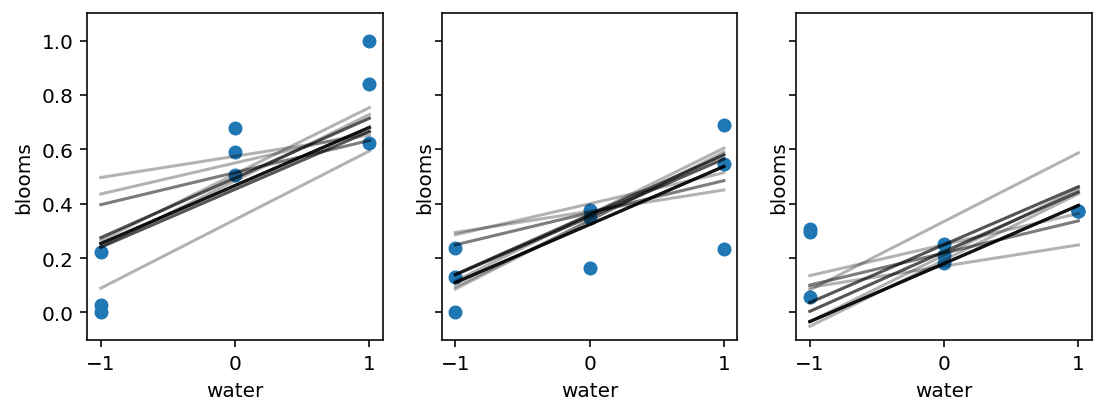

In [48]:
sample_alpha  = posterior_8_4['alpha'][0]
sample_betaW  = posterior_8_4['betaW'][0]
sample_betaS  = posterior_8_4['betaS'][0]    
sample_sigma  = posterior_8_4['sigma'][0]

_, axes = plt.subplots(1, 3, figsize=(9, 3), sharey=True)  # 3 plots in 1 row
for ax, s in zip(axes, range(-1, 2)):
    idx = d.shade_cent == s
    ax.scatter(d.water_cent[idx], d.blooms_std[idx])
    ax.set(xlim=(-1.1, 1.1), ylim=(-0.1, 1.1), xlabel="water", ylabel="blooms")

    shade_cent=s
    water_cent=np.arange(-1, 2)    
    
    jdc_8_4_test = model_8_4(water_cent=tf.cast(water_cent, dtype=tf.float32),
                             shade_cent=tf.cast(shade_cent, dtype=tf.float32))
    
    ds, _ = jdc_8_4_test.sample_distributions(value=[
        sample_alpha, 
        sample_betaW, 
        sample_betaS, 
        sample_sigma, 
        None
    ])
    
    mu = tf.squeeze(ds[-1].distribution.loc)    

    for i in range(20):
        ax.plot(range(-1, 2), mu[i], "k", alpha=0.3)

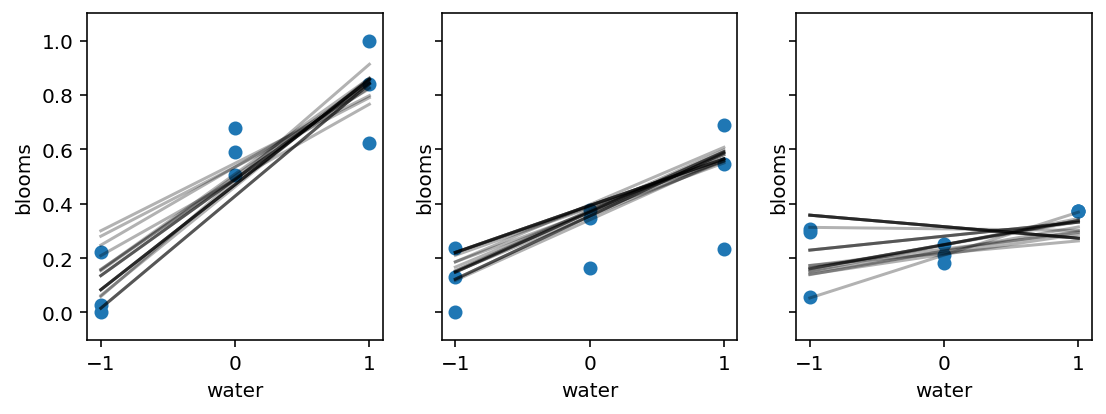

In [49]:
# Code for plotting model 8.5 is not listed in the book but there are corresponding figures so
# draw them here

sample_alpha  = posterior_8_5['alpha'][0]
sample_betaW  = posterior_8_5['betaW'][0]
sample_betaS  = posterior_8_5['betaS'][0]    
sample_betaWS = posterior_8_5['betaWS'][0]
sample_sigma  = posterior_8_5['sigma'][0]
    
_, axes = plt.subplots(1, 3, figsize=(9, 3), sharey=True)  # 3 plots in 1 row
for ax, s in zip(axes, range(-1, 2)):
    idx = d.shade_cent == s
    ax.scatter(d.water_cent[idx], d.blooms_std[idx])
    ax.set(xlim=(-1.1, 1.1), ylim=(-0.1, 1.1), xlabel="water", ylabel="blooms")

    shade_cent=s
    water_cent=np.arange(-1, 2)
    
    jdc_8_5_test = model_8_5(water_cent=tf.cast(water_cent, dtype=tf.float32),
                             shade_cent=tf.cast(shade_cent, dtype=tf.float32))
    
    ds, _ = jdc_8_5_test.sample_distributions(value=[
        sample_alpha,  
        sample_betaW,  
        sample_betaS,  
        sample_betaWS, 
        sample_sigma,  
        None
    ])
    
    mu = tf.squeeze(ds[-1].distribution.loc) 

    for i in range(20):
        ax.plot(range(-1, 2), mu[i], "k", alpha=0.3)

### 8.3.4 Plotting prior predictions

##### Code 8.26

In [50]:
# prior for 8.5
prior_8_5 = jdc_8_5.sample(1000)